<a href="https://colab.research.google.com/github/Hank-Cui/KWHS2019/blob/master/Short_Term_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy import zeros, newaxis
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.animation as animation

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# %pip install --upgrade xgboost
import xgboost as xgb

import os
import time
import PIL
import random
import imageio
from IPython import display
from IPython.display import clear_output
from IPython.display import HTML
from tqdm import tqdm

from __future__ import print_function
#%matplotlib inline 
import argparse

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [54]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Plot Stocks with tech indicators
def plot_stock(company_name, days):
    comp_tic = company_name

    df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
    df = df[-days:]  # Only take the most recent x days

    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

    #plot
    df = tech_indictor(df)

    plt.figure(figsize=(16,9), dpi=80)
    plt.plot(df['Close'], label='Close Price history')
    plt.plot(df['macd'], label='MACD', color='orange')
    plt.plot(df['dea'], label='DEA', color='Magenta')
    plt.plot(df['ma21'], label='MA 21', color='r', linestyle='--')
    plt.plot(df['upper_band'], label='Upper Band', color='c')
    plt.plot(df['lower_band'], label='Lower Band', color='c')
    plt.plot(df['ma7'], label='MA 7', color='g',linestyle='--')

    plt.title(comp_tic+' Stock Price')  # Add a title
    plt.xlabel('Date') 
    plt.ylabel('USD')
    plt.legend(loc='upper left')
    plt.show()

In [0]:
# Add calculated tech indicators in the DataFrame
def tech_indictor(data):

    # Simple Moving Average
    data['ma7'] = data['Close'].rolling(window=7).mean()
    data['ma21'] = data['Close'].rolling(window=21).mean()

    # MACD indicator
    data['ema12'] = data.Close.ewm(span=12, adjust=False).mean()
    data['ema26'] = data.Close.ewm(span=26, adjust=False).mean()
    data['dea'] = data.Close.ewm(span=9, adjust=False).mean()
    data['macd'] = data['ema12']-data['ema26']

    # Bollinger Band
    data['md'] = data.Close.rolling(window=20).std()
    data['upper_band'] = data['ma21'] + (data['md'] * 2)
    data['lower_band'] = data['ma21'] - (data['md'] * 2)

    # Momentum
    data['momentum'] = data['Close'] - 1

    # Exponential Moving Average
    data['ema'] = data['Close'].ewm(com=0.5).mean()

    return data


# Use Fourier Transform in the stock prices to get a general pattern
def fourier_transform(df, plot=False):
    data_FT = df[['Date', 'Close']]
    df["fft_list"] = np.fft.fft(np.array(data_FT['Close']))

    plt.figure(figsize=(14, 7), dpi=100)

    for i in [3, 6, 9, 30]:
        fft_a = np.copy(df["fft_list"].values)
        fft_a[i:-i] = 0
        plt.plot(np.fft.ifft(fft_a), label = 'Fourier Transform of %i components' % i)

    # Plot the fourier transform graph if True
    if plot:
        plt.plot(np.array(data_FT['Close']),  label='Real')
        plt.xlabel('Days')
        plt.ylabel('USD')
        plt.title('{} close stock prices + Fourier transforms of recent {} days'.format(comp_tic, days))
        plt.legend()
        plt.show()
    else:
        pass

    return df


# Fundamental Analysis
def fundamental_analysis():
    print("#ToDo")

In [0]:
def arima_predictions(df, plot=False):

    data = np.array(df['Close'])

    model = ARIMA(data, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    autocorrelation_plot(data)  
    plt.figure(figsize=(10, 7), dpi=80)
    plt.show() 

    train, test = train_test_split(data, test_size=0.33, shuffle=False)

    history = [x for x in train]
    predictions_test = []

    # train data
    for i in range(len(test)): 
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        result = output[0]
        predictions_test.append(result)
        obs = test[i]
        history.append(obs)

    # df['ARIMA'] = predictions
    error = mean_squared_error(test, predictions)  # calculate MSE
    print('Test MSE: %.3f' % error)

    if plot:
        plt.figure(figsize=(12, 6), dpi=100)
        plt.plot(test, label='Real')
        plt.plot(predictions_test, color='red', label='Predicted')
        plt.xlabel('Days')
        plt.ylabel('USD')
        plt.title('ARIMA model on {} stock'.format(comp_tic))
        plt.legend()
        plt.show()

    predictions = []
    for i in range(len(data)): 
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        result = output[0]
        predictions.append(result)
        obs = test[i]
        history.append(obs)
    predictions = [i for value in predictions for i in value]
    df["ARIMA"] = predictions

    return df

In [0]:
def get_Weight(comp_tic, days):
    df_ = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
    df_ = df_[-days:]
    a = tech_indictor(df_)
    b = df_[['ma7','ma21','ema12', 'ema26', 'md', 'macd','upper_band','lower_band']]
    data = b.copy()
    
    y = a['Close']
    X = data

    X_train_FI, X_test_FI, y_train_FI, y_test_FI = train_test_split(X, y, test_size=0.33, shuffle=False)

    regressor = xgb.XGBRegressor(gamma=0.0,
                                n_estimators=1500,
                                base_score=0.7,
                                colsample_bytree=1,
                                learning_rate=0.03)

    xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                            eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                            verbose=False)

    eval_result = regressor.evals_result()
    training_rounds = range(len(eval_result['validation_0']['rmse']))

    plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
    plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Training Vs Validation Error')
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(8,8))
    plt.xticks(rotation='vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
    plt.title('Figure 6: Feature importance of the technical indicators.')
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


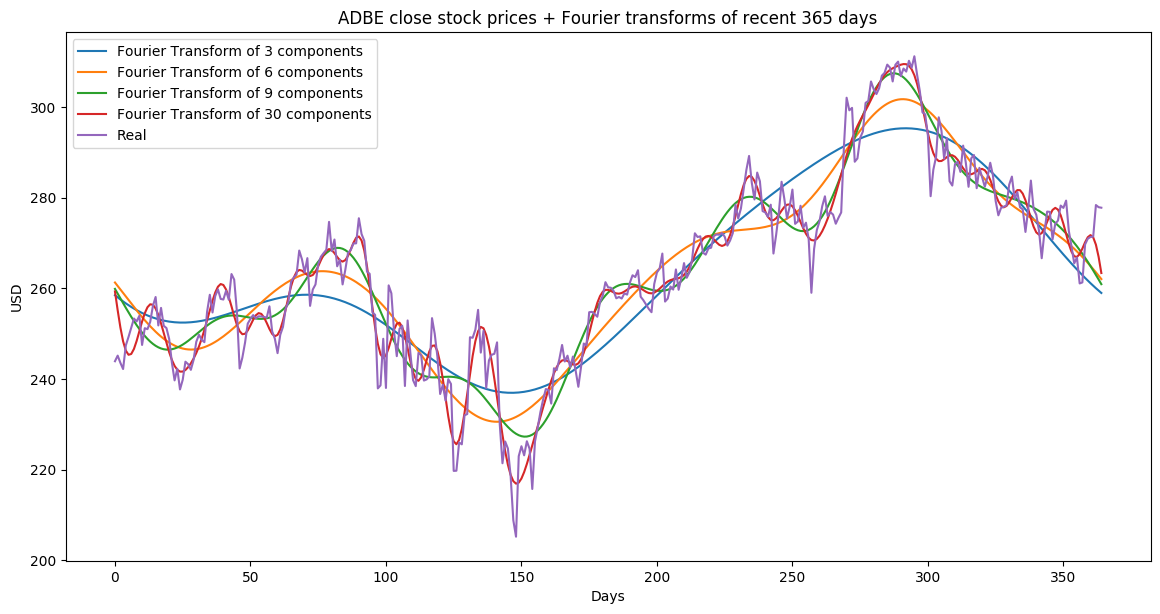

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


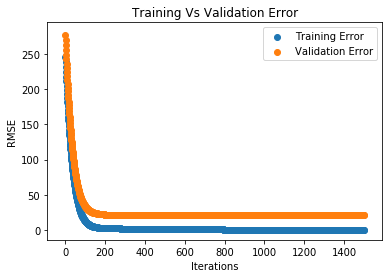

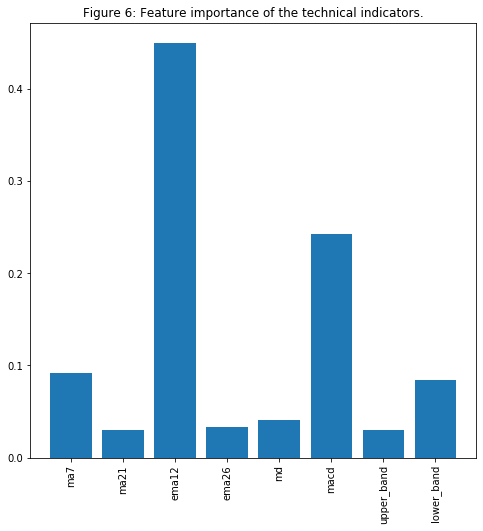

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,ema12,ema26,dea,macd,md,upper_band,lower_band,momentum,ema,fft_list
8010,2018-05-24,243.79,245.90,240.72,245.15,2779600.0,0.0,0.0,0.0,0.0,244.100769,244.001852,244.158000,0.098917,0.0,0.0,0.0,244.15,244.840000,1475.748514+3937.997841j
8011,2018-05-25,245.00,245.79,242.87,243.56,2152900.0,0.0,0.0,0.0,0.0,244.017574,243.969122,244.038400,0.048452,0.0,0.0,0.0,242.56,243.953846,-1876.941409-148.277835j
8012,2018-05-29,242.99,243.39,240.38,242.19,2093400.0,0.0,0.0,0.0,0.0,243.736409,243.837335,243.668720,-0.100927,0.0,0.0,0.0,241.19,242.763250,-1099.320421+1020.555341j
8013,2018-05-30,244.40,248.56,244.39,247.40,2319300.0,0.0,0.0,0.0,0.0,244.300038,244.101236,244.414976,0.198802,0.0,0.0,0.0,246.40,245.867190,624.114569-189.765238j
8014,2018-05-31,247.11,251.52,246.58,249.28,3838400.0,0.0,0.0,0.0,0.0,245.066186,244.484848,245.387981,0.581338,0.0,0.0,0.0,248.28,248.145522,391.641922+129.932736j


In [95]:
# Use this cell to get data

comp_tic = "ADBE"
days = 365

df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
# df = pd.read_csv("/gdrive/My Drive/KWHS2019/hist_data/"+comp_tic+".csv") #- Peter
df = df[-days:]

df = tech_indictor(df)
df = fourier_transform(df, plot=True)
# df = arima_predictions(df)
df = df.fillna(0)

df_y = df.shift(-1)
df_y = df_y.fillna(0)

x_data = df.drop(columns=["fft_list", "Date"]).values
x_data = x_data.reshape(x_data.shape[0], -1, x_data.shape[1])
y_data = df.drop(columns=["fft_list", "Date"]).values
y_data = x_data.reshape(y_data.shape[0], -1, y_data.shape[1])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

get_Weight(comp_tic, days)
df.head()
df_y.head()

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim)
        self.relu = nn.LeakyReLU(0.2, inplace=False)
        # self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, output_size, bias=False)

    def forward(self, input):
        x, _ = self.lstm(input)
        x = self.relu(x)
        x, _ = self.lstm2(x)
        x = self.relu(x)
        x, _ = self.lstm3(x)
        x = self.relu(x)
        x = self.linear(x)
        # x = torch.sigmoid(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv1d(nc, 32, 1, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=False),
            
            # state size. (ndf) x 32 x 32
            nn.Conv1d(32, 64, 1, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=False),
            nn.BatchNorm1d(64, momentum=0.9, affine=False, track_running_stats=False), #affine = gamma & channels
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv1d(64, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=False),
            nn.BatchNorm1d(1, momentum=0.9, affine=False, track_running_stats=False), 

            nn.Linear(18, 50, bias=False),
            nn.BatchNorm1d(64, momentum=0.9, affine=False, track_running_stats=False), 
            nn.LeakyReLU(0.01, inplace=False),
            
            nn.Linear(50, 30, bias=False),
            # nn.ReLU(),
            nn.Linear(30, 1, bias=False),
            nn.Sigmoid()  # Don't change this
        )

    def forward(self, input):
        a = self.main(input)
        x = a.view(a.size(0), -1)
        return x

In [260]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

# Number of channels
nc = 1
npgu = 1

netG = Generator(18, 64, 18, npgu).to(device)
netD = Discriminator(npgu).to(device)

print(netG)
print(netD)

if torch.cuda.is_available():
    netG.cuda
    netD.cuda
    print("Generator and Descriminator Cuda Core is active.")
else:
    pass

Generator(
  (lstm): LSTM(18, 64)
  (lstm2): LSTM(64, 64)
  (lstm3): LSTM(64, 64)
  (relu): LeakyReLU(negative_slope=0.2)
  (linear): Linear(in_features=64, out_features=18, bias=False)
)
Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
    (5): Conv1d(64, 1, kernel_size=(1,), stride=(1,), bias=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
    (8): Linear(in_features=18, out_features=50, bias=False)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=50, out_features=30, bias=False)
    (12): Linear(in_

In [0]:
criterion = nn.BCELoss()

# Create noise
fixed_noise = torch.randn(128, nc, 18, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
lr = 0.01
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Number of workers for dataloader
workers = 2

# Batch Size
batch_size = 128

# Size of feature maps in generator
ngf = 32

nz = 18

In [0]:
class Feature_data_loader(Dataset):

    def __init__(self):
        self.len = x_train.shape[0]
        self.x_data = torch.tensor(x_train)
        self.y_data = torch.tensor(y_train)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

dataset = Feature_data_loader()
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=workers)

# data[0] == input, data[1] == label

In [265]:
# Number of training epochs
num_epochs = 50

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        # Format batch
        real_cpu = data[1].to(device, dtype=torch.float)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 1, 18, device=device)

        # Generate fake image batch with G
        # fake = netG(noise)
        fake = torch.cat((real_cpu[1:],netG(real_cpu[-1].reshape(-1, 1, 18))),0)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ###########################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        print_interval = 1
        if iters % (print_interval * (days//batch_size)) == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(fake)

        iters += 1

Starting Training Loop...
[0/50][0/3]	Loss_D: 1.3813	Loss_G: 0.7476	D(x): 0.5383	D(G(z)): 0.5303 / 0.4873
[0/50][2/3]	Loss_D: 1.3495	Loss_G: 0.7799	D(x): 0.4972	D(G(z)): 0.4715 / 0.5074
[1/50][1/3]	Loss_D: 1.3796	Loss_G: 0.7408	D(x): 0.4977	D(G(z)): 0.4901 / 0.4910
[2/50][0/3]	Loss_D: 1.3810	Loss_G: 0.7554	D(x): 0.5373	D(G(z)): 0.5292 / 0.4843
[2/50][2/3]	Loss_D: 1.3485	Loss_G: 0.7870	D(x): 0.5004	D(G(z)): 0.4742 / 0.5063
[3/50][1/3]	Loss_D: 1.3805	Loss_G: 0.7363	D(x): 0.4930	D(G(z)): 0.4853 / 0.4939
[4/50][0/3]	Loss_D: 1.3817	Loss_G: 0.7586	D(x): 0.5396	D(G(z)): 0.5315 / 0.4828
[4/50][2/3]	Loss_D: 1.3491	Loss_G: 0.7769	D(x): 0.4986	D(G(z)): 0.4725 / 0.5094
[5/50][1/3]	Loss_D: 1.3798	Loss_G: 0.7433	D(x): 0.4969	D(G(z)): 0.4893 / 0.4897
[6/50][0/3]	Loss_D: 1.3806	Loss_G: 0.7577	D(x): 0.5351	D(G(z)): 0.5272 / 0.4830
[6/50][2/3]	Loss_D: 1.3480	Loss_G: 0.7891	D(x): 0.5121	D(G(z)): 0.4857 / 0.5039
[7/50][1/3]	Loss_D: 1.3812	Loss_G: 0.7318	D(x): 0.4897	D(G(z)): 0.4819 / 0.4959
[8/50][0/3]	Lo

In [0]:
def show_losses():
    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(G_losses, label='G_losses')
    plt.plot(D_losses, color='red', label='D_losses')
    plt.xlabel('Time')
    plt.ylabel('Losses')
    plt.title('G and D losses')
    plt.legend()
    plt.show()

def show_prediction():
    prediction = netG(torch.tensor(x_test.reshape(-1, 1, 18), 
                                   dtype=torch.float).to(device))
    prediction = prediction.cpu().detach().numpy()
    real = x_test[:, :, 3]
    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(real, label='Real')
    plt.plot(prediction[:, :, 3], color='red', label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Real vs Predictions')
    plt.legend()
    plt.show()

show_losses()
show_prediction()

In [0]:
def accuracy(input, label):
    output = netG(torch.tensor(input[0])).view(-1)
    print(output)
    # result = (output / test_results)
    # return result

accuracy(x_test, y_test)